<a href="https://colab.research.google.com/github/Rogerio-mack/grupo7_algoritmos_quanticos/blob/main/Atividade_UA3_UA4_QAOA_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TAREFA UA3-UA4**
### **CIMATEC - CPGINV-HPC-0013 | Algoritmos de Computação Quântica**



# **Alunos**

```
Bruno Zolotareff dos Santos
Lihoy Aguiar Bellissimo
Marcos Aurélio Duarte Carvalho
Rafael Marin Machado de Souza
Rogério de Oliveira
Thiago Soares Assimos
Roberto Machado Velho
```


# Conteúdo

[Introdução]()

1. [Problema do Caixeiro Viajante (*Traveling Salesman Problem*, TSP)]()

> 1.1. [Algoritmo de Otimização Aproximada Quântica (Quantum Approximate Optimization Algorithm, QAOA)]()

2. [Solução Passo a Passo TSP (n=3)]()

> 2.1. Gera um grafo TSP aleatório

> 2.2. Solução Clássica, Força Bruta ($O(n!)$)

> 2.3. Solução Clássica por Otimização Quadrática

> 2.4. Solução na Abordagem Quântica

>> 2.4.1. Mapeia o TSP para um Circuito Quântico

>> 2.4.2. Executa o Circuito Quântico

>> 2.4.3. Exibindo a
Distribuição das Soluções

3. [Pipelines Completos]()

> 3.1. Pipeline Completo para TSP (n=3)

> 3.2. Pipeline Completo para TSP (n=4)

> 3.3. Pipeline Completo para TSP (n>4)

4. [Discussão dos resultados e Conclusão]()

# Introdução

Este trabalho implementa e analisa um algoritmo **QAOA (Quantum Approximate Optimization Algorithm)**  com o Qiskit, para solução do problema do Caixeiro Viajante (TSP), para instâncias com 3,4 "cidades" e acima, e compara seus resultados com uma solução clássica.

Este noteboook está organizado do seguinte modo:

1. A **seção 1** traz definições e conceitos aqui empregados.
2. A **seção 2** detalha passo a passo a solução para um TSP$(n=3)$.
3. A **seção 3** implementa um pipeline completo de solução TSP$(n)$ - clássica e quântica - , com a **seção 3.1.** executando o pipeline para $n=3$, **seção 3.2.** para $n=4$, etc.
4. A **seção 4** traz o relatório final.

Emprega-se o simulador Quântico do `Qiskit`.



# 1. Problema do Caixeiro Viajante (*Traveling Salesman Problem*, TSP)

O Problema do Caixeiro Viajante consiste em nos nós de um grafo buscar o ciclo *hamiltoniano*, um caminho fechado que utiliza cada vértice do grafo uma única vez, mais curto que pode ser percorrido por cada um dos nós. A solução geral é desconhecida e não se espera que exista um algoritmo que a encontre de forma eficiente (por exemplo, em tempo polinomial). **É um NP problema, sendo a solução de força bruta um problema da ordem $O(n^2)$**.

Em outros termos o problema consiste em encontrar o ciclo hamiltoniano mais curto em um gráfico $G = ( V,E)$ com $n = |V|$ nós e distâncias, $w_{ij}$ (distância do vértice $i$ para vértice $j$). Um ciclo hamiltoniano é descrito por $N^2$ variáveis $x_{i,p}$,onde $i$ representa o nó $p$ representa sua ordem em um ciclo prospectivo. A variável de decisão assume o valor 1 se a solução ocorrer no nó $i$ na ordem de tempo $p$. Cada nó deve aparecer uma única vez no ciclo o que é traduzido pelas seguintes restrições:

$$\sum_{i} x_{i,p} = 1 ~~\forall p$$
$$\sum_{p} x_{i,p} = 1 ~~\forall i.$$

Para nós nessa ordenação, se $x_{i,p}$ e $x_{j,p+1}$ são ambos 1, então deve haver uma penalidade de energia se $( i , j ) \notin E$ (isto é, não está conectado no gráfico). Essa penalidade ser traduz pela restrição:

$$\sum_{i,j\notin E}\sum_{p} x_{i,p}x_{j,p+1}>0,$$

onde se assume a condição de contorno dos ciclos hamiltonianos $( p = N) ≡ ( p = 0 )$. Entretanto, **aqui, assume-se sempre um grafo totalmente conectado** e esse termo não será incluído. A distância que precisa ser minimizada é, portanto:

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}.$$

Tudo isso pode ser reunido em uma única função objetivo a ser minimizada:

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}+ A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2,$$

onde $A$ é um parâmetro livre. É preciso garantir que $A$ é grande o suficiente para que essas restrições sejam respeitadas. Uma maneira de fazer isso é escolher $A$ de modo que $A > \mathrm{max}(w_{ij})$.

Esse problema geral de otimização, será então, mais adiante mapeado para solução em um computador quântico, buscando-se minimizar um Hamiltoniano de Ising.

# 1.1. Algoritmo de Otimização Aproximada Quântica (*Quantum Approximate Optimization Algorithm*, QAOA)

O problema TSP, assim como outros problemas de otimização, podem ser tratados em um computador quântico, através de algoritmos híbridos como Algoritmo de Otimização Aproximada Quântica (QAOA). O QAOA é um algoritmo híbrido, o que significa que ele requer etapas tanto quânticas quanto "clássicas". Resumidamente, os seguintes passos são requeridos em um algoritmo QAOA:

1. Mapear o problema de otimização para um circuito quântico.
2. Otimizar iterativamente os parâmetros do circuito. O otimizador, é um otimizador "clássico", que executa, portanto, em computador clássico.
3. Após encontrarmos os melhores parâmetros, realizamos uma execução final do circuito otimizado para obter a solução do problema.

A seguir é **implementada uma solução QAOA com o Qiskit, para solução do problema TSP para 3,4 ou mais nós.**

# Instalação e importação das bibliotecas

In [ ]:
#@markdown import Qiskit
try:
  import qiskit; print(qiskit.__version__)
  from qiskit.circuit.library import n_local
  from qiskit.primitives import StatevectorSampler
  print('Qiskit imported')
except ImportError:
  print('Install Qiskit')
  !pip install -q qiskit
  !pip install -q qiskit[visualization]
  import qiskit; print(qiskit.__version__)
  from qiskit.circuit.library import n_local
  from qiskit.primitives import StatevectorSampler
  print('Qiskit installed and imported')

2.2.3
Qiskit imported


In [ ]:
#@markdown import Qiskit Optimization
try:
  from qiskit_optimization.algorithms import MinimumEigenOptimizer
  from qiskit_optimization.applications import Tsp
  from qiskit_optimization.minimum_eigensolvers import NumPyMinimumEigensolver, SamplingVQE
  from qiskit_optimization.utils import algorithm_globals
  from qiskit_optimization.converters import QuadraticProgramToQubo
  print('Qiskit Optimization imported')
except ImportError:
  !pip install qiskit_optimization
  from qiskit_optimization.algorithms import MinimumEigenOptimizer
  from qiskit_optimization.applications import Tsp
  from qiskit_optimization.minimum_eigensolvers import NumPyMinimumEigensolver, SamplingVQE
  from qiskit_optimization.utils import algorithm_globals
  from qiskit_optimization.converters import QuadraticProgramToQubo
  print('Qiskit Optimization installed and imported')




Qiskit Optimization imported


In [ ]:
#@markdown import Qiskit Algorithms
try:
  from qiskit_algorithms.optimizers import ADAM, SPSA, COBYLA, L_BFGS_B, SLSQP
  from qiskit_algorithms import QAOA
  from qiskit_optimization.utils import algorithm_globals
  print('Qiskit Algorithms imported')
except ImportError:
  !pip install qiskit_algorithms
  from qiskit_algorithms.optimizers import ADAM, SPSA, COBYLA, L_BFGS_B, SLSQP
  from qiskit_algorithms import QAOA
  print('Qiskit Algorithms installed and imported')

Qiskit Algorithms imported


In [ ]:
#@markdown Outros imports
try:
  import networkx as nx
  print('NetworkX imported')
except ImportError:
  print('Install NetworkX')
  import networkx as nx
  print('NetworkX installed and imported')

import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline
import time

NetworkX imported


## Funções Auxiliares

In [ ]:
def draw_graph(G, colors, pos, ax):
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=ax, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=ax)

def draw_tsp_solution(G, order, colors, pos, ax):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=ax, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels, ax=ax)


# 2. Solução Passo a Passo TSP$(n=3)$

## 2.1. Gera um grafo TSP aleatório

Geramos um grafo aleatório de $n$ nós, assumindo sempre um grafo totalmente conectado.

In [ ]:
def generate_tsp_problem(n,seed=123):
  num_qubits = n**2
  tsp = Tsp.create_random_instance(n, seed=seed)
  adj_matrix = nx.to_numpy_array(tsp.graph)
  print("Matriz de Adjacências: \n\n", adj_matrix, '\n')

  colors = ["r" for node in tsp.graph.nodes]
  pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
  return tsp, colors, pos, adj_matrix

Matriz de Adjacências: 

 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]] 



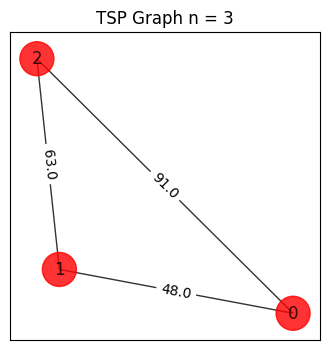

In [ ]:
tsp, colors, pos, adj_matrix = generate_tsp_problem(3)

fig, ax = plt.subplots(1,1, figsize=(4,4))

draw_graph(tsp.graph, colors, pos, ax)
plt.title(f"TSP Graph n = {adj_matrix.shape[0]}")
plt.show()

## 2.2. Solução Clássica, Força Bruta ($O(n!)$)



In [ ]:
from itertools import permutations

def brute_force_tsp(w):
    N = w.shape[0]
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance

    print("Solution:", best_order)
    print("Distance:", last_best_distance)
    return last_best_distance, best_order

Solution: (0, 1, 2)
Distance: 202.0
Execution time: 0.000313 seconds.




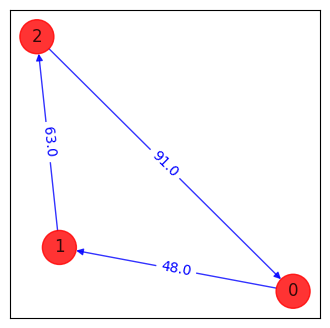

In [ ]:
start_time = time.time()
best_distance, z = brute_force_tsp(adj_matrix)
print(f"Execution time: {time.time() - start_time:.6f} seconds.\n\n")

fig, ax = plt.subplots(1,1, figsize=(4,4))
draw_tsp_solution(tsp.graph, z, colors, pos, ax)


## 2.3. Solução Clássica por Otimização Quadrática

Além da força bruta, podemos transformar o TSP em um problema de otimização quadrática e aplicar um otimizador clássico para solução.

In [ ]:
def solve_tsp_classical(tsp):
  exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
  qp = tsp.to_quadratic_program()
  result = exact.solve(qp)

  print(qp.prettyprint())
  print(result.prettyprint())

  x = tsp.sample_most_likely(result.min_eigen_solver_result.eigenstate)
  z = tsp.interpret(x)
  adj_matrix = nx.to_numpy_array(tsp.graph)

  print("Solution:", z)
  print("Distance:", tsp.tsp_value(z, adj_matrix))
  return z, adj_matrix



Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2

objective function value: 202.0
variable values: x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0
status: SUCCESS
Solution: [0, 1, 2]
Distance: 202.0
Execution time: 0.109287 seconds.




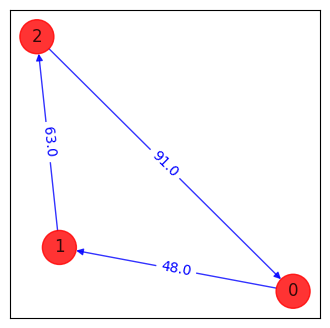

In [ ]:
start_time = time.time()
z, adj_matrix = solve_tsp_classical(tsp)
print(f"Execution time: {time.time() - start_time:.6f} seconds.\n\n")

fig, ax = plt.subplots(1,1, figsize=(4,4))
draw_tsp_solution(tsp.graph, z, colors, pos, ax)

## 2.4. Solução na Abordagem Quântica

### 2.4.1. Mapeia o TSP para um Circuito Quântico

Para mapear o TSP para um circuito quântico fazemos as seguintes etapas:

1. Convertemos o TSP para um problema de otimização quadrática `to_quadratic_program()`
2. Convertemos o problema de otimização quadrática para problema de Otimização Binária Quadrática Irrestrita (QUBO) `QuadraticProgramToQubo().convert()`.

$$C(\textbf{x}) \Longrightarrow f_Q(\textbf{x}) = \sum_{i=1}^{n}\sum_{j=1}^{n}Q_{ij}x_i x_j$$

3. Empregamos o métdo `to_ising()` para criar um objeto `SparsePauliOp`, que representa o operador matricial de $n \times n$ qubits (onde $n$ é o número de nós do grafo TSP).

In [ ]:
def gera_Ising_Hamiltonian(tsp):
  qp = tsp.to_quadratic_program()
  qp2qubo = QuadraticProgramToQubo()
  qubo = qp2qubo.convert(qp)
  qubitOp, offset = qubo.to_ising()
  print("Offset:", offset)
  print("Ising Hamiltonian:")
  print(str(qubitOp))
  print("Num Qubits:", qubitOp.num_qubits)
  return qubitOp, offset


In [ ]:
qubitOp, offset = gera_Ising_Hamiltonian(tsp)

Offset: 7581.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-1282.5 +0.j, -1282.5 +0.j, -1282.5 +0.j, -1268.5 +0.j, -1268.5 +0.j,
 -1268.5 +0.j, -1290.  +0.j, -1290.  +0.j, -1290.  +0.j,   606.5 +0.j,
   606.5 +0.j,   606.5 +0.j,    12.  +0.j,    12.  +0.j,   606.5 +0.j,
    22.75+0.j,    22.75+0.j,   606.5 +0.j,    12.  +0.j,   606.5 +0.j,
    12.  +0.j,    22.75+0.j,   606.5 +0.j,    22.75+0.j,    

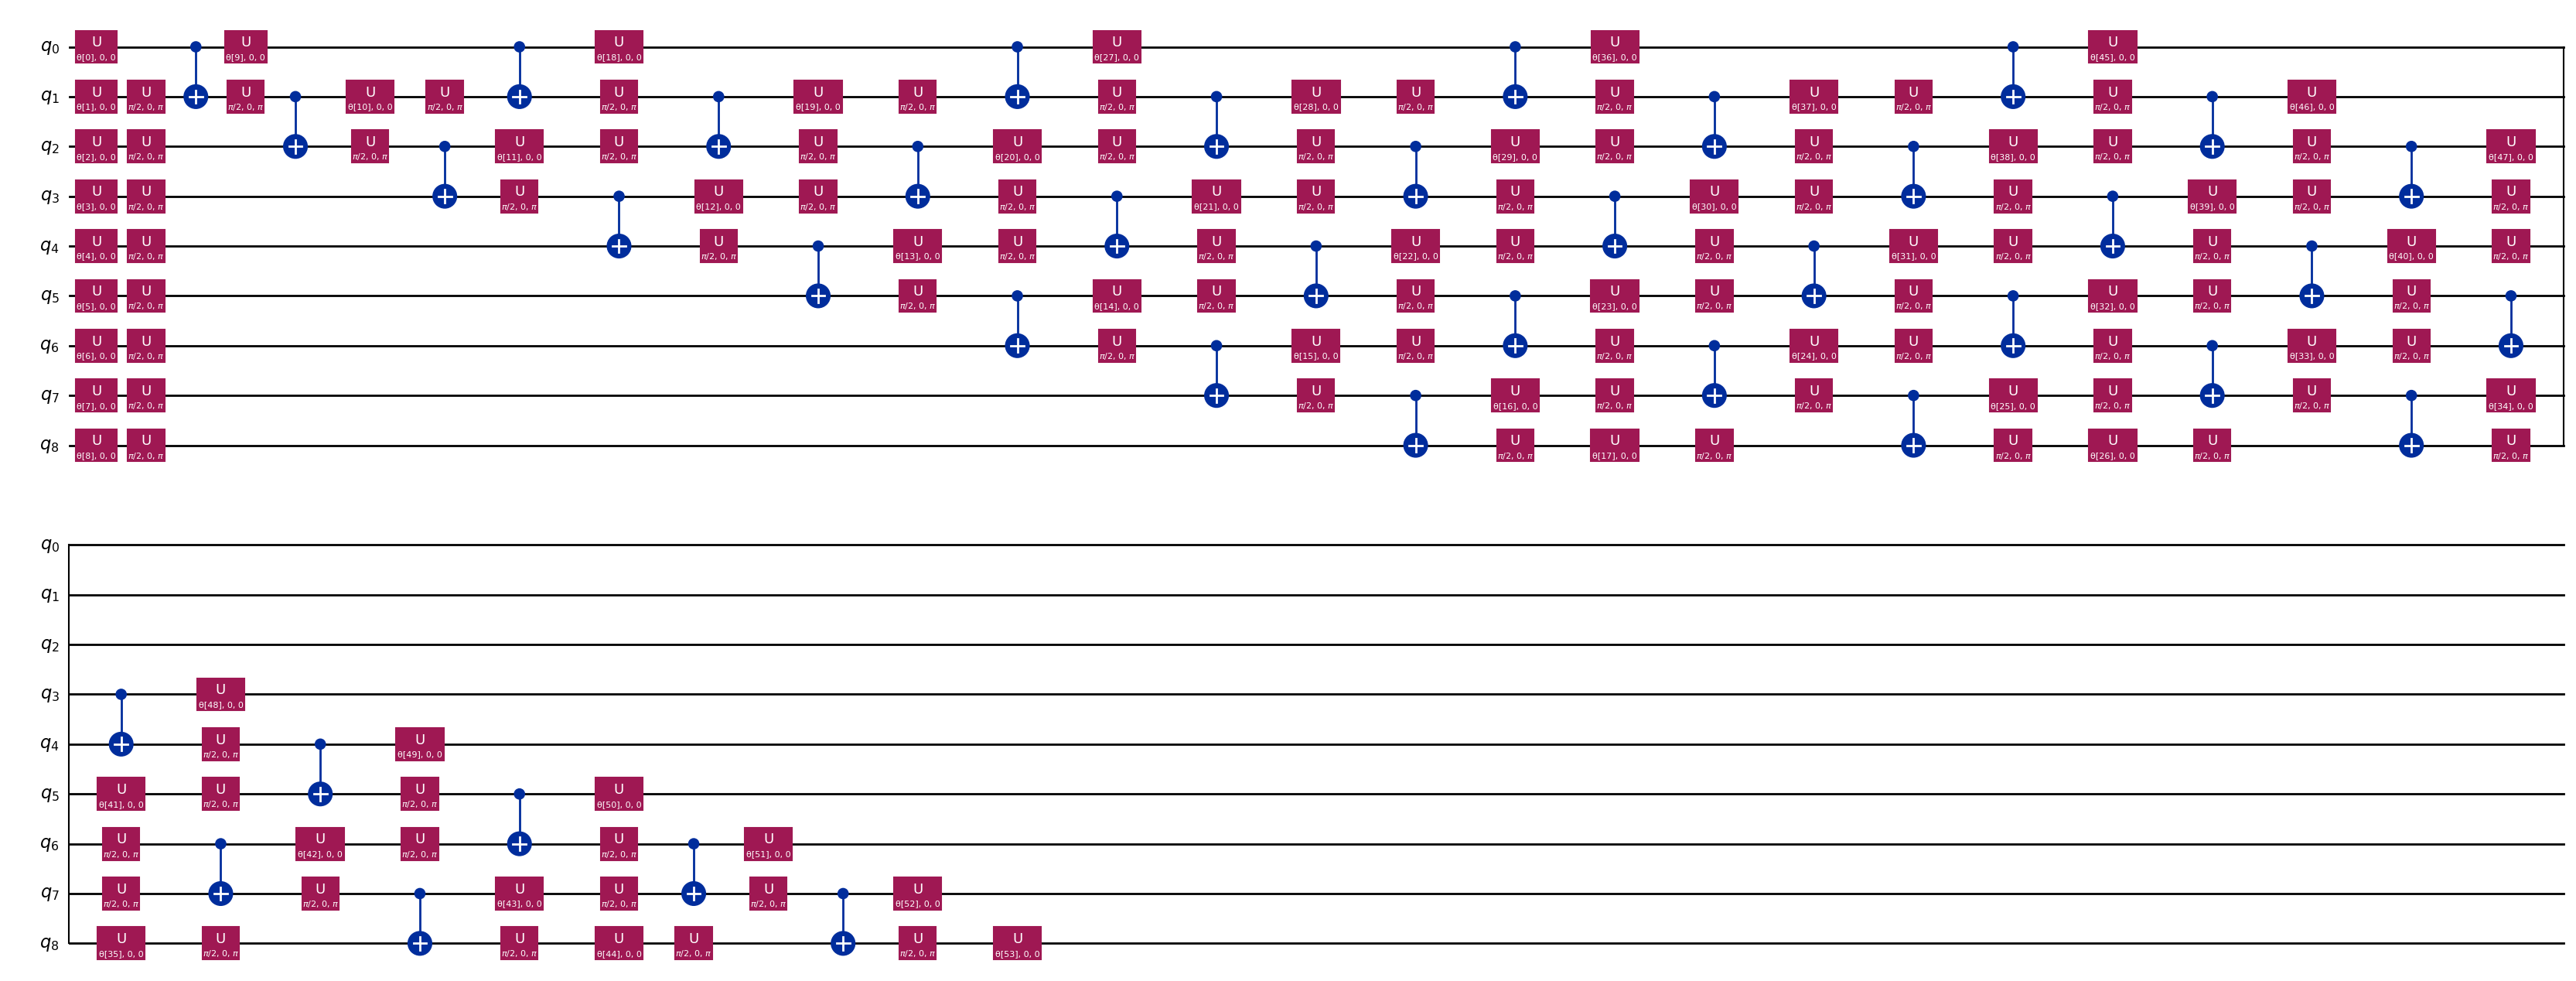

In [ ]:
ry = n_local(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")

display(ry.decompose(reps= 3).draw(output= "mpl" , style= "iqp" , fold= 50 ))

### 2.4.2. Executa o Circuito Quântico

A classe `SamplingVQE` emprega um circuito quântico (`ry`) e um otimizador clássico. Vários otimizadores clássicos foram testados (SPSA, ADAM, COBYLA, L_BFGS_B), mas ao final optou-se por empregar o SPSA. A classe  `SamplingVQE` utiliza o otimizador, e executa iterativamente o circuito quântico para  encontrar os melhores parâmetros. Após a otimização do circuito o resultado final é obtido pela execução da  classe `MinimumEigenOptimizer()`, que salva o resultado final.


In [ ]:
def run_QAOA(ry, qubitOp, tsp, adj_matrix, optimizer=SPSA(maxiter=1000),seed=123):
  algorithm_globals.random_seed = seed
  seed = seed

  print("Matriz de Adjacências QAOA: \n\n", adj_matrix, '\n')
  print(f'Running QAOA with {optimizer.setting.split('\n')[0]}, with maxiter = {optimizer.maxiter}...')
  vqe = SamplingVQE(sampler=StatevectorSampler(seed=seed), ansatz=ry, optimizer=optimizer)
  result = vqe.compute_minimum_eigenvalue(qubitOp)

  print("energy:", result.eigenvalue.real)
  print("time:", result.optimizer_time)
  x = tsp.sample_most_likely(result.eigenstate)
  z = tsp.interpret(x)
  print("solution:", z)
  print("solution objective:", tsp.tsp_value(z, adj_matrix))

  return result, ry, vqe, z

Matriz de Adjacências QAOA: 

 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]] 

Running QAOA with Optimizer: SPSA, with maxiter = 1000...
energy: -7367.2431640625
time: 51.118812084198
solution: [1, 2, 0]
solution objective: 202.0
Execution time: 51.150215 seconds.




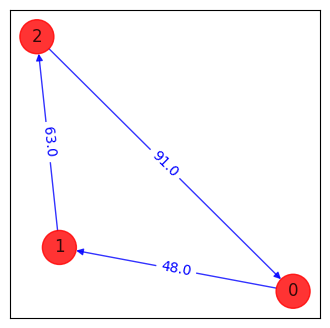

In [ ]:
# optimizer = SPSA(maxiter=1000)
# optimizer = ADAM(maxiter=1000, lr=0.001)
# optimizer = COBYLA(maxiter=1000)
# optimizer = L_BFGS_B(maxiter=1000,maxfun=1000)

start_time = time.time()
result, ry, vqe, z = run_QAOA(ry, qubitOp, tsp, adj_matrix, optimizer=SPSA(maxiter=1000))
print(f"Execution time: {time.time() - start_time:.6f} seconds.\n\n")

fig, ax = plt.subplots(1,1, figsize=(4,4))
draw_tsp_solution(tsp.graph, z, colors, pos, ax)

### 2.4.3. Exibindo a Distribuição das Soluções

A distribuição das soluções pode ser observada empregando-se o `plot_distribution()` do `qiskit`.

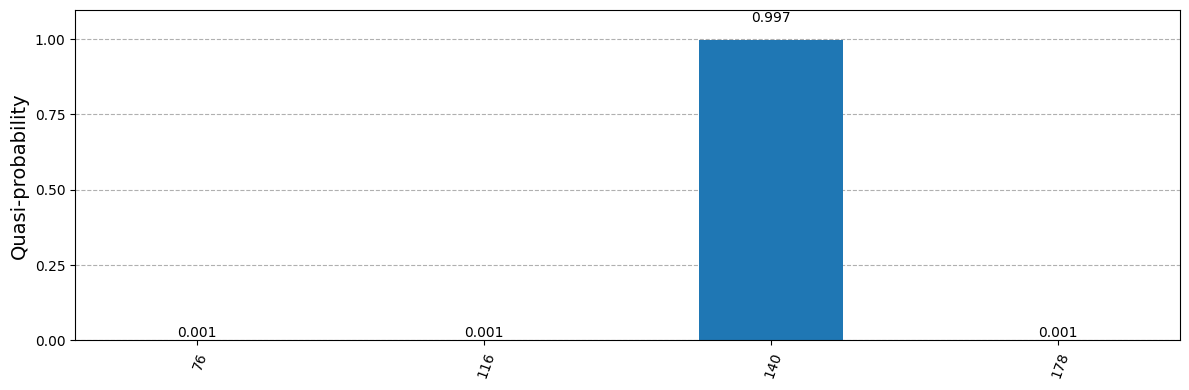

In [ ]:
from qiskit.visualization import plot_distribution

samp_dist = result.eigenstate
plot_distribution(samp_dist, figsize=(12, 4))

Mas uma representação mais clara da solução pode ser obtida a partir do string de bits de cada solução. Cada ponto é codificado em $n$ bits quânticos em uma espécie de codificação de 1 bit (001 – 1º nó, 010 – 2º, 100 – 3º, etc.). Para 3 pontos, são 12 bits no total.

```
Bitstring: 010 001 100, probability: 0.999023
```

Entretanto, temos que lembrar que **o `Qiskit` emprega uma notação inversa à convencional, sendo o último qubit o mais significativo e, portanto**, `010 001 100` representa a solução [1, 2, 0]  de sequência de nós.

$$[1, 2, 0] \rightarrow_{+1} [2, 3, 1] \rightarrow_{\text{to binary}} 010\_100\_001 \rightarrow_{\text{to qiskit notation}} 010\_001\_100$$

In [ ]:
final_bits = result.eigenstate.binary_probabilities()

n_top = 10
final_bits_reduced = {key: value for key, value in sorted(
   final_bits.items(), key=lambda x: x[1], reverse=True
)[:n_top]}
for key, value in final_bits_reduced.items():
   print(f"Bitstring: {key}, probability: {value:02f}")

Bitstring: 010001100, probability: 0.997070
Bitstring: 001110100, probability: 0.000977
Bitstring: 001001100, probability: 0.000977
Bitstring: 010110010, probability: 0.000977


In [ ]:
result.eigenstate.binary_probabilities()

{'010001100': 0.9970703125,
 '001110100': 0.0009765625,
 '001001100': 0.0009765625,
 '010110010': 0.0009765625}

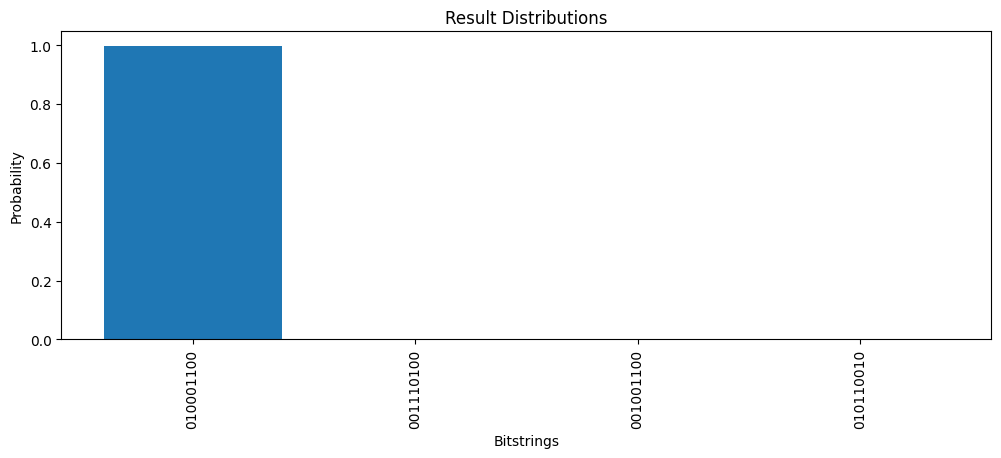

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=90)
plt.title("Result Distributions")
plt.xlabel("Bitstrings")
plt.ylabel("Probability")
xv = list(final_bits_reduced.keys())
yv = list(final_bits_reduced.values())
ax.bar(xv, yv, color="tab:blue")
plt.show()

# Pipelines Completo

## 3.1. Pipeline Completo para TSP$(n=3)$

Aqui, no Pipeline Completo, por simplicidade é empregada somente a solução clássica do método de otimização quadrática e suprimidos os display do circuito quântico e distribuição das soluções.

In [ ]:
def solve_tsp_compare(n,maxiter,seed=123):

  history = {}

  # Gera um grafo TSP aleatório
  tsp, colors, pos, adj_matrix = generate_tsp_problem(n,seed=seed)
  fig, ax = plt.subplots(1,1, figsize=(4,4))

  draw_graph(tsp.graph, colors, pos, ax)
  plt.title(f"TSP Graph n = {adj_matrix.shape[0]}")
  plt.show()

  # Solução Clássica por Otimização Quadrática
  start_time = time.time()
  z, adj_matrix = solve_tsp_classical(tsp)
  print(f"Execution time: {time.time() - start_time:.6f} seconds.\n\n")
  history['classical'] = time.time() - start_time

  fig, ax = plt.subplots(1,1, figsize=(4,4))
  draw_tsp_solution(tsp.graph, z, colors, pos, ax)
  plt.show()

  # Mapeia o TSP para um Circuito Quântico
  start_time = time.time()
  qubitOp, offset = gera_Ising_Hamiltonian(tsp)
  ry = n_local(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
  history['create circuit'] = time.time() - start_time

  # Executa o Circuito Quântico
  start_time = time.time()
  result, ry, vqe, z = run_QAOA(ry, qubitOp, tsp, adj_matrix, optimizer=SPSA(maxiter=maxiter),seed=seed)
  print(f"Execution time: {time.time() - start_time:.6f} seconds.\n\n")
  history['QAOA'] = time.time() - start_time

  fig, ax = plt.subplots(1,1, figsize=(4,4))
  draw_tsp_solution(tsp.graph, z, colors, pos, ax)
  plt.show()

  print(history)

  return


Matriz de Adjacências: 

 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]] 



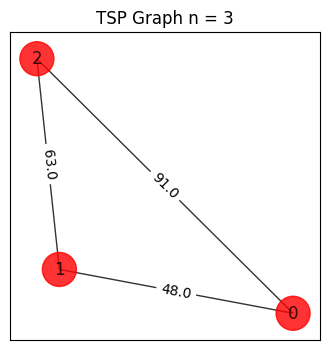

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2

objective function value: 202.0
variable values: x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0
status: SUCCESS
Solution: [0, 1, 2]
Distance: 202.0
Execution time: 0.197168 seconds.




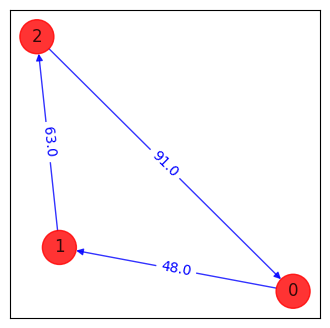

Offset: 7581.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-1282.5 +0.j, -1282.5 +0.j, -1282.5 +0.j, -1268.5 +0.j, -1268.5 +0.j,
 -1268.5 +0.j, -1290.  +0.j, -1290.  +0.j, -1290.  +0.j,   606.5 +0.j,
   606.5 +0.j,   606.5 +0.j,    12.  +0.j,    12.  +0.j,   606.5 +0.j,
    22.75+0.j,    22.75+0.j,   606.5 +0.j,    12.  +0.j,   606.5 +0.j,
    12.  +0.j,    22.75+0.j,   606.5 +0.j,    22.75+0.j,    

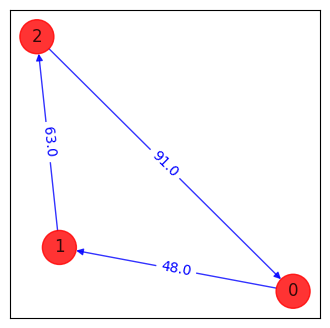

{'classical': 0.19717741012573242, 'create circuit': 0.02863001823425293, 'QAOA': 43.98241925239563}


In [ ]:
n = 3                                  # número de nós do TSP
maxiter = 1000                         # para o otimizador

solve_tsp_compare(n,maxiter=maxiter)

## 3.2. Pipeline Completo para TSP$(n=4)$

Notar que para menos de 1000 iterações o algoritmo converge para soluções de mínimo local e, portanto, não obtêm a solução.

> **ATENÇÃO**

> 1. A execução pode levar **mais de 40min no Google Colab.**

> 2. A solução, **PODE NÃO CONVERGIR**. Por isso o `seed` para manter a reprodutibilidade.


Matriz de Adjacências: 

 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]] 



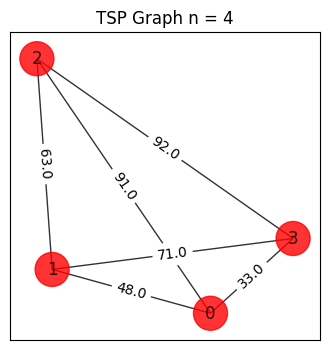

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

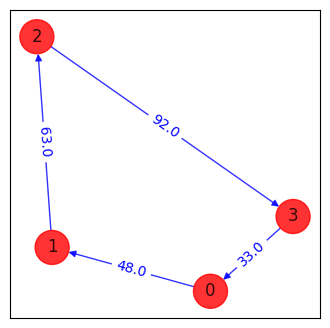

Offset: 51756.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIZIIIIIIZ', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIIZ', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIZI', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIIZI', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIIIZI', 'IIIZIIIIIIIIIIZI', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIZII', 'IIIIIIIIZIIIIZII', 'IIIIIIZIIIIIIZII', 'IIIIIZIIIIIIIZII', 'IIIIZIIIIIIIIZII', 'IIZIIIIIIIIIIZII', 'IZIIIIIII

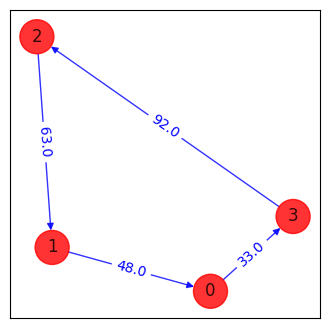

{'classical': 1.395388126373291, 'create circuit': 0.045143842697143555, 'QAOA': 2225.810848236084}


In [ ]:
n = 4                                  # número de nós do TSP
maxiter = 1000                         # para o otimizador

solve_tsp_compare(n,maxiter=maxiter)

## 3.3. Pipeline Completo para TSP$(n>4)$

> **ATENÇÃO**

> 1. Execução falha no Colab (plano Free) por empregar mais de 12GB RAM.

> 2. Foram feitas várias tentativas com diferentes otimizadores além do SPSA como o COBYLA, ADAM, incluindo o L_BFGS_B	(Limited-memory BFGS Bound optimizer) que, a princípio, minimizaria o uso de memória. Os resultados, entretanto, foram os mesmos de falha na execução.

In [ ]:
n = 5                                  # número de nós do TSP
maxiter = 1000                         # para o otimizador

solve_tsp_compare(n,maxiter=maxiter)

In [1]:
2225 / 60

37.083333333333336

# 4. Discussão dos resultados e Conclusões

Resumindo os resultados obtidos aqui, embora a solução quântica QAOA tenha chegado às soluções do problema TSP para $n=3$ e $n=4$, podemos ver que para problemas práticos maiores uma abordagem quântica ainda não é efetiva.

### 4.1. O QAOA apresenta um grande overhead

O QAOA apresenta um grande overhead para sua implementação, o que inclui:

1. Construção do Hamiltoniano do problema (cost Hamiltonian) e do mixer
2. Loop de otimização clássica (COBYLA, SPSA, L_BFGS_B etc.)
3. Execução repetida do circuito quântico
4. Amostragem (shots) para estimar a função custo

Para $n=3$ ou $n=4$, o problema clássico é trivial (respectivamente $3!=6$ e $4!=24$ rotas). A solução clássica por força bruta ou mesmo a Otimização Quadrática Clássica (empregada em nosso pipeline para as medidas comparativas) é instantânea. Enquanto o QAOA, por outro lado, faz algo muito mais "pesado" para resolver um problema minúsculo. Por isso, é esperado e pudemos observar aqui, que o **QAOA é centenas ou milhares de vezes mais lento**.

<br>

| TSP n | Tempo Solução Clássica | Tempo Solução Quântica QAOA |  
| - | - | - |
| $3$ | $0.19s$ | $43.9s$ |
| $4$ | $1.39s$ |  $\textbf{37 min}$  |

<br>

### 4.2 Explosão de recursos para $n$ grande

No TSP com QAOA se faz:

$$
x_{i,t} =
\begin{cases}
1, & \text{se cidade } i \text{ está na posição } t, \\
0, & \text{caso contrário}.
\end{cases}
$$

Isso implica que **o número de qubits para o circuito na solução QAOA é de $n^2$**. O problema de recursos, entretanto, vem do fato de que **o espaço de estados nesse caso é $2^{n^2}$**. O simulador clássico precisa então armazenar $2^{n^2}$ valores! Em termos práticos,

- $n=5 \longrightarrow 2^{25} \approx 33$ milhões de amplitudes
- $n=6 \longrightarrow 2^{36} \approx 10^{10}$ milhões de amplitudes (**impraticável**)

Por isso já era esperado que, embora tenhamos feito várias tentativas com diferentes otimizadores além do SPSA (como o COBYLA, ADAM, incluindo o L_BFGS_B	Limited-memory BFGS Bound optimizer que, a princípio, minimizaria o uso de memória), não obtivemos sucesso na execução para $n>4$ (no caso com estouro de memória RAM - 12GB RAM).

<br>

Desse modo, **o QAOA ainda não é prático hoje para problemas de otimização reais, nem em hardware quântico atual nem em simulação clássica, exceto para instâncias muito pequenas**. Não há, também, prova de vantagem quântica para QAOA em problemas NP-difíceis e nosso  experimento confirma exatamente isso. Apesar disso, o QAOA é objeto de intensa pesquisa por ser um modelo promissor para exploração futura de hardware quântico escalável, além de servir como base teórica para o desenvolvimento de algoritmos híbridos.




# Bibliografia

[1] de Oliveira, M.C., Fanchini, F.F., Arruda, L.G.E. *Introdução à Computação Quântica: Teoria e Prática com Python e Qiskit.* Editora Quati. Edição dos autores (2025).

[2] IBM QUANTUM. *Quantum approximate optimization algorithm*. Disponível em: https://quantum.cloud.ibm.com/docs/en/tutorials/quantum-approximate-optimization-algorithm. Acesso em: 22 dez. 2025.

[3] IBM QUANTUM. *Variational Algorithm Design*. Disponível em: https://quantum.cloud.ibm.com/learning/en/courses/variational-algorithm-design. Acesso em: 22 dez. 2025.
